# Nenana Ice Classic - Logistic Regression Modeling

In [1]:
# imports

import numpy as np
import pandas as pd

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# pipeline and preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.pipeline import make_pipeline
from category_encoders import WOEEncoder
from sklearn.decomposition import KernelPCA as KPCA

# models
from sklearn.linear_model import LogisticRegressionCV

# evaluation
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn import metrics # accuracy_score, confusion_matrix, plot_confusion_matrix

# Pretty Print to make some outputs easier to read
import pprint

# filter warnings
import warnings
warnings.filterwarnings("ignore")

import gc # garbage collection

In [2]:
def stringify(data):
    data = pd.DataFrame(data)
    for c in data.columns.tolist():
        data[c] = data[c].astype(str)
    return data

## Modeling

#### How good does my model have to be?

The percentage of non-events in the data is 98.27%, so that is the target accuracy my model aims to beat.

#### Create training and testing DataFrames

In [3]:
training_df = pd.read_csv('../data/model_training_data.csv')

In [4]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2546 entries, 0 to 2545
Columns: 196 entries, Date to flowVolume_MA-std_dev_10
dtypes: float64(187), int64(7), object(2)
memory usage: 3.8+ MB


In [5]:
testing_df = pd.read_csv('../data/model_testing_data.csv')

In [6]:
testing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Columns: 196 entries, Date to flowVolume_MA-std_dev_10
dtypes: float64(187), int64(7), object(2)
memory usage: 810.2+ KB


In [7]:
# columns to exclude from models (dates and target info)
exclude = ['winningTime', 'winningDate',  'Date']

In [8]:
used_cols = [c for c in training_df.columns if c not in exclude]

In [9]:
no_ma_cols = [c for c in training_df.columns.tolist() if not c.endswith(('3', '5', '7', '10'))]
used_no_ma_cols = [c for c in no_ma_cols if c not in exclude]

In [10]:
pprint.pprint(no_ma_cols, compact = True)
pprint.pprint(used_no_ma_cols, compact = True)

['Date', 'moonPhase', 'humidity', 'windSpeed', 'windBearing', 'cloudCover',
 'uvIndex', 'precipIntensity', 'winningTime', 'iceThickness', 'flowVolume',
 'dayOfYear', 'winningDate', 'daylightHours', 'precip_rain', 'precip_snow',
 'temperatureAvg', 'numHotDays', 'numColdDays', 'accumulatedSnow']
['moonPhase', 'humidity', 'windSpeed', 'windBearing', 'cloudCover', 'uvIndex',
 'precipIntensity', 'iceThickness', 'flowVolume', 'dayOfYear', 'daylightHours',
 'precip_rain', 'precip_snow', 'temperatureAvg', 'numHotDays', 'numColdDays',
 'accumulatedSnow']


---
#### Logistic Regression Baseline Model Excluding Moving Average Features

In [11]:
target = 'winningDate'

scaler = RobustScaler()
encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)

clf_lr = LogisticRegressionCV(class_weight='balanced',
                              Cs = [0.1],
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              max_iter = 20,
                              n_jobs=-1,
                              random_state=42)

pipe = make_pipeline(scaler, binner, objectify, encoder, clf_lr)

X_train, y_train = training_df[used_no_ma_cols].values, training_df[target].values

In [12]:
pipe.fit(X_train, y_train)
X_test = testing_df[used_no_ma_cols]
y_test = testing_df[target]
y_pred = pipe.predict(X_test)

In [13]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.9338374291115312


In [14]:
sns.set_style("whitegrid", {'axes.grid' : False})

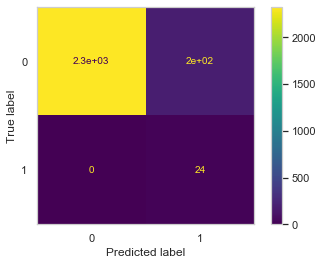

In [15]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

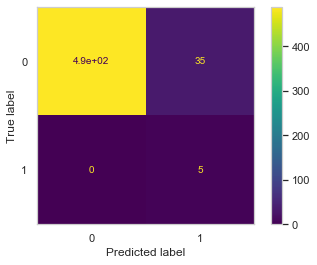

In [16]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [17]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([0.00138444, 0.0004262 , 0.00065635, 0.00176525, 0.00106042])

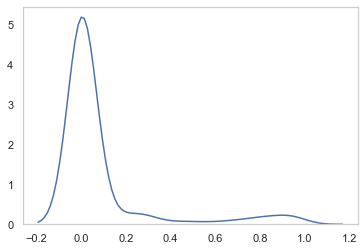

In [18]:
sns.kdeplot(y_pred);

In [19]:
metrics.confusion_matrix(y_test, y_pred > 0.54)

array([[490,  34],
       [  0,   5]])

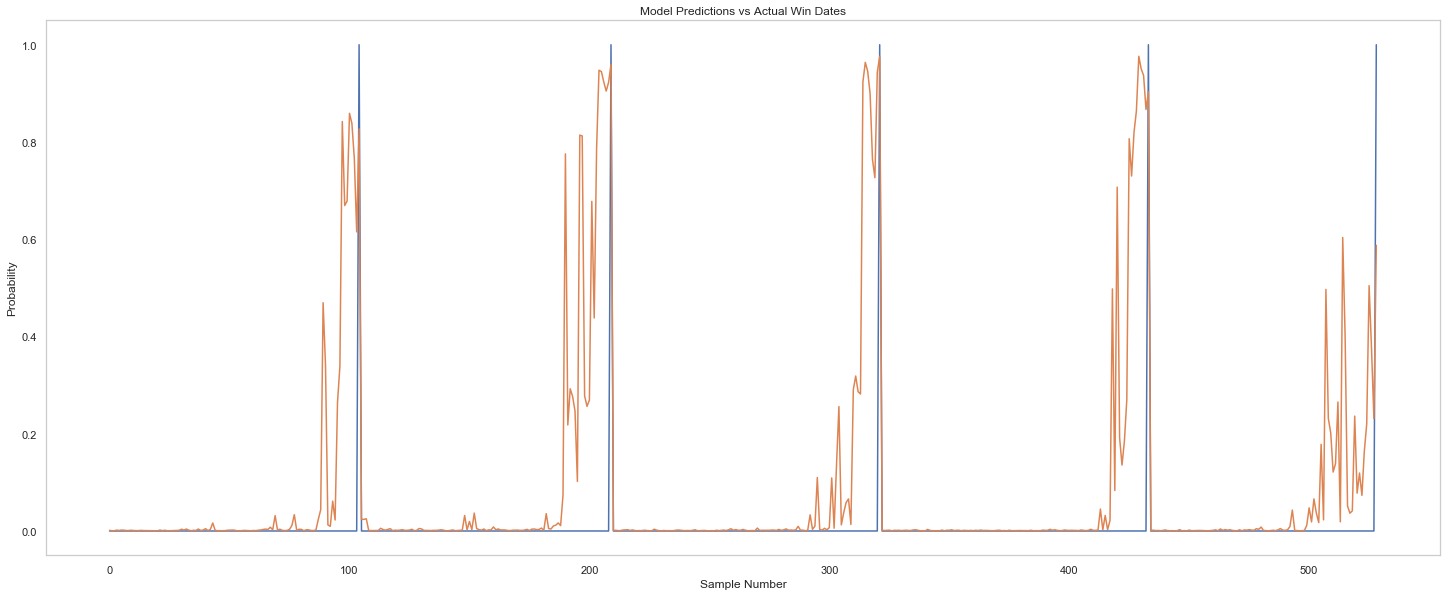

In [20]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

In [21]:
# get the top features by coefficient
feature_values = []
for n, v in enumerate(clf_lr.coef_[0]):
    feature_values.append((n, v))
sorted(feature_values, key = lambda x: abs(x[1]), reverse = True)

[(8, 0.8882271746918798),
 (13, 0.7270670966278415),
 (1, 0.5859911549717632),
 (2, 0.565164639710728),
 (4, 0.5379211365048511),
 (14, 0.5313153206874635),
 (3, 0.381007310421187),
 (0, 0.3420152769145813),
 (7, -0.30699689430654403),
 (15, -0.19204543122173792),
 (9, 0.16677042042519133),
 (10, 0.13378718426373304),
 (16, -0.10435903523391048),
 (6, 0.1024519560216417),
 (11, 0.1024519560216417),
 (12, 0.1024519560216417),
 (5, -0.09381823453107566)]

In [22]:
# list the feature names so the top feature list can be made
feature_names = {}
for n, v in enumerate(used_no_ma_cols):
    feature_names[n] = v
pprint.pprint(feature_names, compact = True)

{0: 'moonPhase',
 1: 'humidity',
 2: 'windSpeed',
 3: 'windBearing',
 4: 'cloudCover',
 5: 'uvIndex',
 6: 'precipIntensity',
 7: 'iceThickness',
 8: 'flowVolume',
 9: 'dayOfYear',
 10: 'daylightHours',
 11: 'precip_rain',
 12: 'precip_snow',
 13: 'temperatureAvg',
 14: 'numHotDays',
 15: 'numColdDays',
 16: 'accumulatedSnow'}


In [23]:
best_no_ma_features = []
for value in sorted(feature_values, key = lambda x: abs(x[1]), reverse = True)[:13]:
    if value[0] in feature_names:
        best_no_ma_features.append(feature_names[value[0]])

In [24]:
best_no_ma_features

['flowVolume',
 'temperatureAvg',
 'humidity',
 'windSpeed',
 'cloudCover',
 'numHotDays',
 'windBearing',
 'moonPhase',
 'iceThickness',
 'numColdDays',
 'dayOfYear',
 'daylightHours',
 'accumulatedSnow']

---
#### Logistic Regression Model Using Top Features From Baseline Excluding Moving Average Features Model

In [25]:
target = 'winningDate'

scaler = RobustScaler()
encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
clf_lr = LogisticRegressionCV(class_weight='balanced',
                              Cs = [0.1],
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)
pipe = make_pipeline(scaler, binner, objectify, encoder, clf_lr)

X_train, y_train = training_df[best_no_ma_features].values, training_df[target].values

In [26]:
pipe.fit(X_train, y_train)
X_test = testing_df[best_no_ma_features]
y_test = testing_df[target]
y_pred = pipe.predict(X_test)

In [27]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.9338374291115312


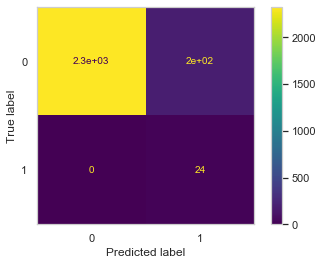

In [28]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

In [29]:
metrics.confusion_matrix(y_test, y_pred)

array([[489,  35],
       [  0,   5]])

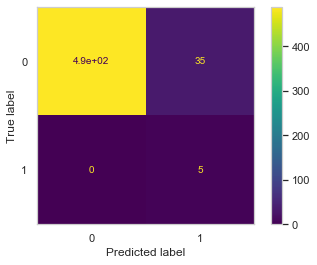

In [30]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [31]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([0.00130668, 0.00039846, 0.00061809, 0.00167312, 0.00099722])

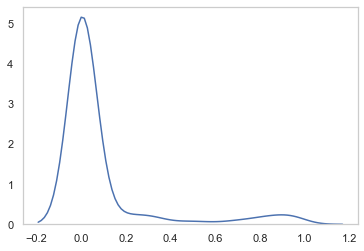

In [32]:
sns.kdeplot(y_pred);

In [33]:
metrics.confusion_matrix(y_test, y_pred > 0.765)

array([[499,  25],
       [  1,   4]])

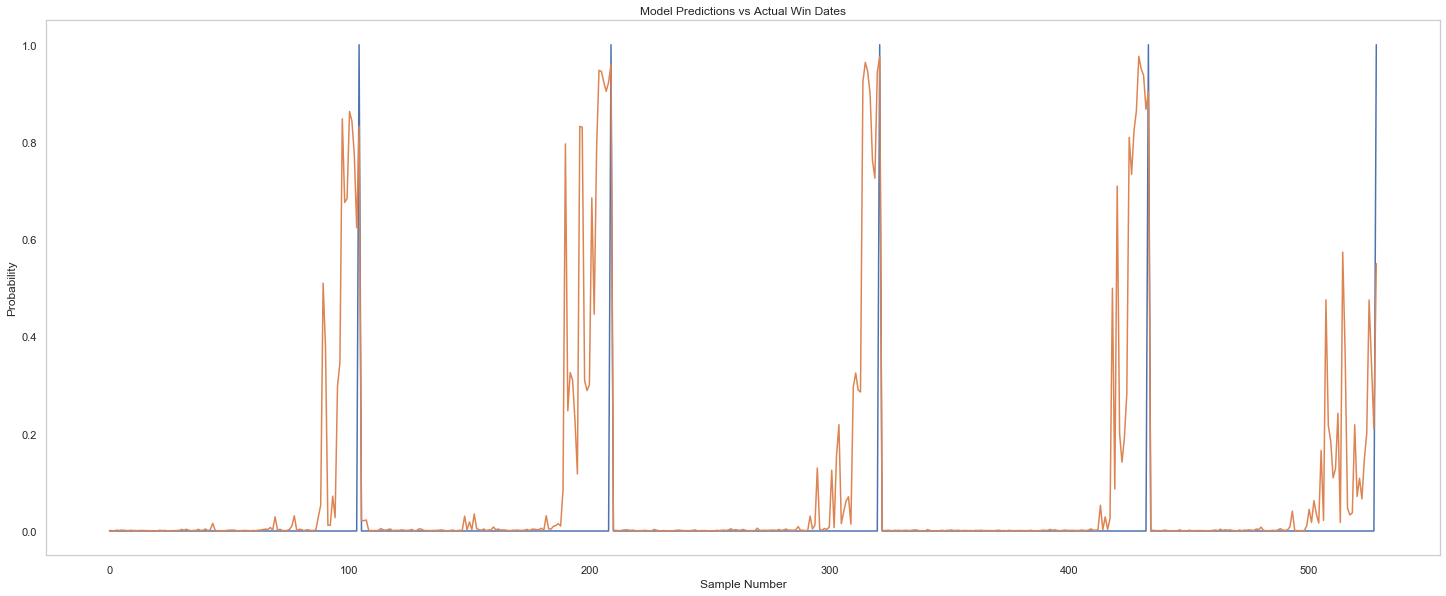

In [34]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

---
#### Baseline Logistic Regression Model Including Moving Average Features

In [35]:
# baseline Logistic Regression model using all features
target = 'winningDate'

scaler = RobustScaler()
encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
clf_lr = LogisticRegressionCV(class_weight='balanced', # class imbalance in data
                              Cs = [0.001], # more features seem to respond better to stronger regularization
                              cv = TimeSeriesSplit(), # time series, so use TimeSeriesSplit
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)

pipe = make_pipeline(scaler, binner, objectify, encoder, clf_lr)

X_train, y_train = training_df[used_cols].values, training_df[target].values

In [36]:
pipe.fit(X_train, y_train)
X_test = testing_df[used_cols]
y_test = testing_df[target]
y_pred = pipe.predict(X_test)

In [37]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.9149338374291115


In [38]:
sns.set_style("whitegrid", {'axes.grid' : False})

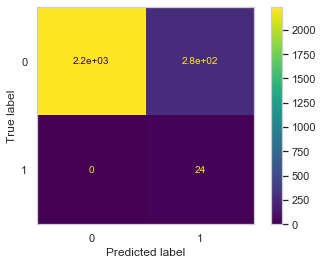

In [39]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

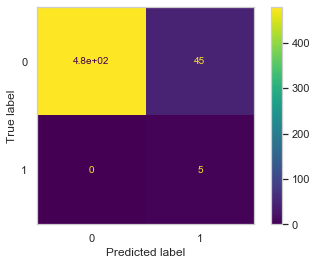

In [40]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [41]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([0.03186625, 0.02595262, 0.03532281, 0.03707754, 0.06569299])

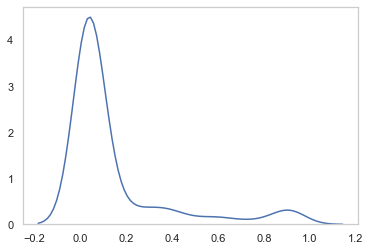

In [42]:
sns.kdeplot(y_pred);

In [43]:
metrics.confusion_matrix(y_test, y_pred > 0.658)

array([[492,  32],
       [  0,   5]])

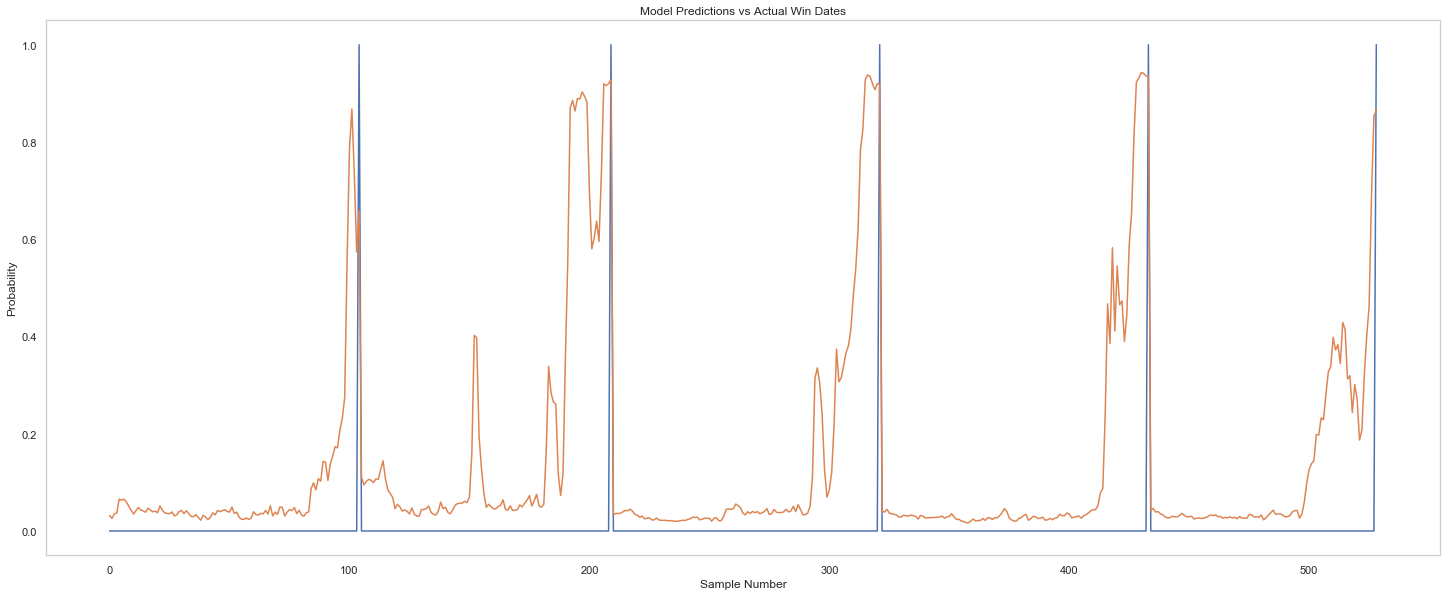

In [44]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

---
#### Initial Approach
At this point, feature dimensionality was high. Initially, I dealt with it by fitting the model and pulling out the most important features (measured by coefficient weights).

In [45]:
# get the top features by coefficient
feature_values = []
for n, v in enumerate(clf_lr.coef_[0]):
    feature_values.append((n, v))
sorted(feature_values, key = lambda x: abs(x[1]), reverse = True)[:31]

[(150, 0.12506250577503494),
 (154, 0.11949714105943228),
 (189, 0.09443114611715338),
 (185, 0.07710721102193174),
 (152, 0.0683774791918262),
 (181, 0.06202815400796002),
 (140, 0.05979452627122543),
 (186, 0.05597463301266853),
 (95, 0.05580527387645068),
 (160, 0.05432699888246427),
 (188, 0.053631765012761665),
 (128, 0.05349198095285229),
 (177, 0.051987286491485214),
 (190, 0.050291443530695784),
 (124, 0.04963120502899918),
 (184, 0.04841334445209379),
 (148, 0.04732512428702419),
 (158, 0.046838036941248336),
 (96, 0.04597601341954946),
 (85, 0.04290241043675947),
 (13, 0.04133416369492542),
 (8, 0.03957101050639912),
 (192, 0.036374278468511455),
 (159, -0.032329039146187295),
 (183, 0.030760108529941734),
 (180, 0.030127937338396808),
 (93, 0.03001313992950883),
 (191, 0.028499407112555882),
 (157, 0.028424170182851753),
 (17, 0.02785777108988543),
 (63, 0.02713476205257479)]

In [46]:
# list the feature names so the top 30 feature list can be made
feature_names = {}
for n, v in enumerate(used_cols):
    feature_names[n] = v
pprint.pprint(feature_names, compact = True)

{0: 'moonPhase',
 1: 'humidity',
 2: 'windSpeed',
 3: 'windBearing',
 4: 'cloudCover',
 5: 'uvIndex',
 6: 'precipIntensity',
 7: 'iceThickness',
 8: 'flowVolume',
 9: 'dayOfYear',
 10: 'daylightHours',
 11: 'precip_rain',
 12: 'precip_snow',
 13: 'temperatureAvg',
 14: 'numHotDays',
 15: 'numColdDays',
 16: 'accumulatedSnow',
 17: 'humidity_MA_3',
 18: 'humidity_MA-slope_3',
 19: 'humidity_MA-accel_3',
 20: 'humidity_MA-std_dev_3',
 21: 'humidity_MA_5',
 22: 'humidity_MA-slope_5',
 23: 'humidity_MA-accel_5',
 24: 'humidity_MA-std_dev_5',
 25: 'humidity_MA_7',
 26: 'humidity_MA-slope_7',
 27: 'humidity_MA-accel_7',
 28: 'humidity_MA-std_dev_7',
 29: 'humidity_MA_10',
 30: 'humidity_MA-slope_10',
 31: 'humidity_MA-accel_10',
 32: 'humidity_MA-std_dev_10',
 33: 'windSpeed_MA_3',
 34: 'windSpeed_MA-slope_3',
 35: 'windSpeed_MA-accel_3',
 36: 'windSpeed_MA-std_dev_3',
 37: 'windSpeed_MA_5',
 38: 'windSpeed_MA-slope_5',
 39: 'windSpeed_MA-accel_5',
 40: 'windSpeed_MA-std_dev_5',
 41: 'windSp

In [47]:
lr_best_cols = []
for value in sorted(feature_values, key = lambda x: abs(x[1]), reverse = True)[:31]:
    if value[0] in feature_names:
        lr_best_cols.append(feature_names[value[0]])

In [48]:
# check correlations in top 20 features
training_df[lr_best_cols].corr()

,numHotDays_MA-slope_5,numHotDays_MA-slope_7,flowVolume_MA_10,flowVolume_MA_7,numHotDays_MA-std_dev_5,flowVolume_MA_5,temperatureAvg_MA-std_dev_7,flowVolume_MA-slope_7,uvIndex_MA-accel_10,numHotDays_MA-std_dev_10,...,flowVolume,flowVolume_MA-std_dev_10,numHotDays_MA-accel_10,flowVolume_MA-accel_5,flowVolume_MA-std_dev_3,uvIndex_MA_10,flowVolume_MA-accel_10,numHotDays_MA_10,humidity_MA_3,windBearing_MA-accel_10
numHotDays_MA-slope_5,1.000000,0.972981,0.438787,0.455402,0.998178,0.464808,-0.218213,0.464268,-0.034038,0.916005,...,0.490696,0.456836,0.564245,0.256639,0.448900,0.644794,0.388664,0.649963,-0.223041,0.086759
numHotDays_MA-slope_7,0.972981,1.000000,0.456112,0.473815,0.970256,0.483676,-0.256753,0.484041,-0.047559,0.969019,...,0.511718,0.476833,0.434826,0.275317,0.472258,0.650573,0.405609,0.684718,-0.207356,0.100180
flowVolume_MA_10,0.438787,0.456112,1.000000,0.992441,0.433948,0.977242,-0.140849,0.774429,-0.008027,0.469716,...,0.918688,0.825827,0.082204,0.200583,0.641550,0.395493,0.503642,0.462580,-0.055292,0.024438
flowVolume_MA_7,0.455402,0.473815,0.992441,1.000000,0.449941,0.995152,-0.150358,0.834530,-0.005569,0.487359,...,0.950648,0.882799,0.085912,0.216360,0.689902,0.413108,0.554613,0.464544,-0.074632,0.027539
numHotDays_MA-std_dev_5,0.998178,0.970256,0.433948,0.449941,1.000000,0.458946,-0.210369,0.457157,-0.033004,0.913968,...,0.483961,0.449494,0.568700,0.251865,0.441651,0.646583,0.382466,0.645764,-0.223194,0.086422
flowVolume_MA_5,0.464808,0.483676,0.977242,0.995152,0.458946,1.000000,-0.155722,0.882943,-0.002671,0.497268,...,0.971719,0.922268,0.087482,0.235398,0.734623,0.420838,0.615741,0.461452,-0.086969,0.032006
temperatureAvg_MA-std_dev_7,-0.218213,-0.256753,-0.140849,-0.150358,-0.210369,-0.155722,1.000000,-0.169792,-0.017630,-0.278617,...,-0.173591,-0.162463,0.047618,-0.119472,-0.174306,-0.391922,-0.148330,-0.311552,0.133254,-0.044364
flowVolume_MA-slope_7,0.464268,0.484041,0.774429,0.834530,0.457157,0.882943,-0.169792,1.000000,0.019221,0.496391,...,0.954731,0.986788,0.087592,0.389834,0.902928,0.414929,0.873745,0.405109,-0.136763,0.046644
uvIndex_MA-accel_10,-0.034038,-0.047559,-0.008027,-0.005569,-0.033004,-0.002671,-0.017630,0.019221,1.000000,-0.043796,...,0.010962,0.017106,-0.012160,0.039568,0.028294,-0.042500,0.041502,-0.021047,-0.030652,-0.088913
numHotDays_MA-std_dev_10,0.916005,0.969019,0.469716,0.487359,0.913968,0.497268,-0.278617,0.496391,-0.043796,1.000000,...,0.524995,0.488228,0.213666,0.275415,0.483398,0.657195,0.415512,0.733163,-0.201867,0.080980


---
#### Experimenting With Moving Averages

Since the top features including moving average features are highly correlated, I decided to do a series of experiments using each set of moving averages seperately to see which set was most useful.

##### 3 Day Moving Average Features

In [49]:
ma3_cols = [c for c in training_df.columns.tolist() if not c.endswith(('5', '7', '10'))]
used_ma3_cols = [c for c in ma3_cols if c not in exclude]

In [50]:
# Logistic Regression model using all 3 day moving average features
target = 'winningDate'

scaler = RobustScaler()
encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
clf_lr = LogisticRegressionCV(class_weight='balanced', # class imbalance in data
                              Cs = [0.02], # more features seem to respond better to stronger regularization
                              cv = TimeSeriesSplit(), # time series, so use TimeSeriesSplit
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)

pipe = make_pipeline(scaler, binner, objectify, encoder, clf_lr)

X_train, y_train = training_df[used_ma3_cols].values, training_df[target].values

In [51]:
pipe.fit(X_train, y_train)
X_test = testing_df[used_ma3_cols]
y_test = testing_df[target]
y_pred = pipe.predict(X_test)

In [52]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.9243856332703214


In [53]:
sns.set_style("whitegrid", {'axes.grid' : False})

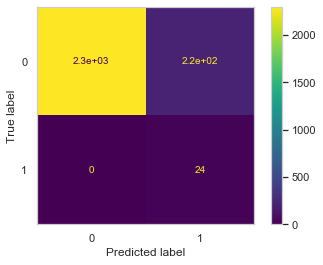

In [54]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

In [55]:
metrics.confusion_matrix(y_test, y_pred)

array([[484,  40],
       [  0,   5]])

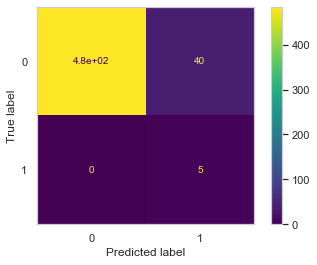

In [56]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [57]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([0.01544118, 0.00423633, 0.00851792, 0.00664032, 0.00759742])

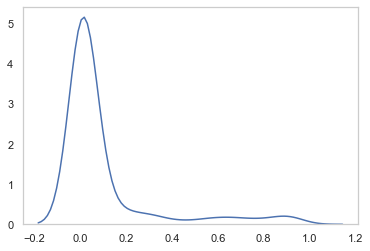

In [58]:
sns.kdeplot(y_pred);

In [59]:
metrics.confusion_matrix(y_test, y_pred > 1e-10)

array([[  0, 524],
       [  0,   5]])

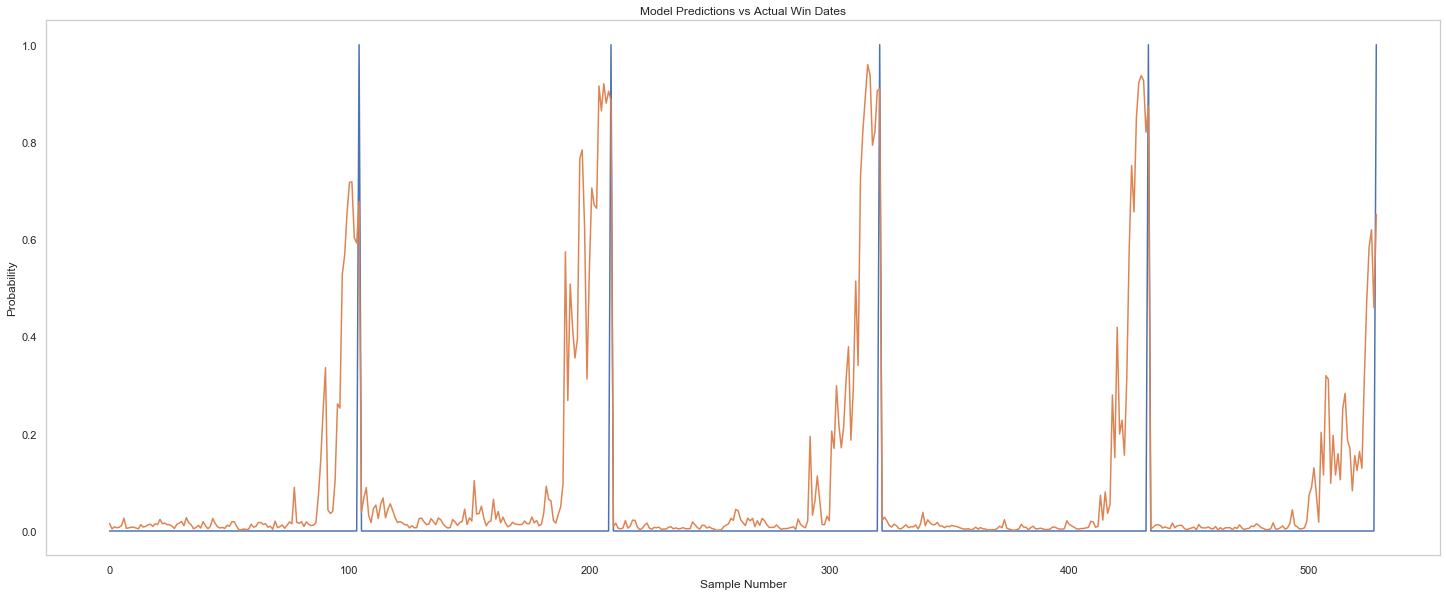

In [60]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

In [61]:
# get the top features by coefficient
feature_values = []
for n, v in enumerate(clf_lr.coef_[0]):
    feature_values.append((n, v))
sorted(feature_values, key = lambda x: abs(x[1]), reverse = True)[:31]

[(20, 0.3566248607514806),
 (57, 0.3477292242979001),
 (29, 0.3059029984909806),
 (22, 0.2642211009549688),
 (13, 0.2510939808984539),
 (52, 0.24980947615985336),
 (17, 0.2392946457547462),
 (2, 0.23452512551530508),
 (8, 0.218758522625433),
 (4, 0.21757383159315696),
 (27, 0.20305701687847685),
 (44, 0.1602710245673535),
 (32, 0.15573498877971795),
 (55, -0.15571647023630314),
 (47, 0.15217239452239853),
 (49, 0.15148751437729183),
 (60, 0.1489553181374246),
 (56, -0.14798734470243183),
 (35, -0.14387102440134214),
 (7, -0.1421696839403027),
 (14, 0.13630680694216363),
 (33, 0.13430405783728433),
 (19, 0.13385118833131293),
 (1, 0.1303744477828085),
 (46, -0.13028892586955673),
 (54, -0.12578386094149233),
 (41, -0.11511678472639426),
 (23, -0.1082990652817358),
 (59, 0.10590475667458381),
 (48, 0.10461974539576943),
 (16, -0.10163749467242673)]

In [62]:
# list the feature names so the top 30 feature list can be made
feature_names = {}
for n, v in enumerate(used_ma3_cols):
    feature_names[n] = v
pprint.pprint(feature_names, compact = True)

{0: 'moonPhase',
 1: 'humidity',
 2: 'windSpeed',
 3: 'windBearing',
 4: 'cloudCover',
 5: 'uvIndex',
 6: 'precipIntensity',
 7: 'iceThickness',
 8: 'flowVolume',
 9: 'dayOfYear',
 10: 'daylightHours',
 11: 'precip_rain',
 12: 'precip_snow',
 13: 'temperatureAvg',
 14: 'numHotDays',
 15: 'numColdDays',
 16: 'accumulatedSnow',
 17: 'humidity_MA_3',
 18: 'humidity_MA-slope_3',
 19: 'humidity_MA-accel_3',
 20: 'humidity_MA-std_dev_3',
 21: 'windSpeed_MA_3',
 22: 'windSpeed_MA-slope_3',
 23: 'windSpeed_MA-accel_3',
 24: 'windSpeed_MA-std_dev_3',
 25: 'windBearing_MA_3',
 26: 'windBearing_MA-slope_3',
 27: 'windBearing_MA-accel_3',
 28: 'windBearing_MA-std_dev_3',
 29: 'cloudCover_MA_3',
 30: 'cloudCover_MA-slope_3',
 31: 'cloudCover_MA-accel_3',
 32: 'cloudCover_MA-std_dev_3',
 33: 'uvIndex_MA_3',
 34: 'uvIndex_MA-slope_3',
 35: 'uvIndex_MA-accel_3',
 36: 'uvIndex_MA-std_dev_3',
 37: 'precipIntensity_MA_3',
 38: 'precipIntensity_MA-slope_3',
 39: 'precipIntensity_MA-accel_3',
 40: 'precipI

In [63]:
lr_best_ma3_cols = []
for value in sorted(feature_values, key = lambda x: abs(x[1]), reverse = True)[:31]:
    if value[0] in feature_names:
        lr_best_ma3_cols.append(feature_names[value[0]])

In [64]:
lr_best_ma3_cols

['humidity_MA-std_dev_3',
 'flowVolume_MA_3',
 'cloudCover_MA_3',
 'windSpeed_MA-slope_3',
 'temperatureAvg',
 'numHotDays_MA-std_dev_3',
 'humidity_MA_3',
 'windSpeed',
 'flowVolume',
 'cloudCover',
 'windBearing_MA-accel_3',
 'iceThickness_MA-std_dev_3',
 'cloudCover_MA-std_dev_3',
 'numColdDays_MA-accel_3',
 'temperatureAvg_MA-accel_3',
 'numHotDays_MA_3',
 'flowVolume_MA-std_dev_3',
 'numColdDays_MA-std_dev_3',
 'uvIndex_MA-accel_3',
 'iceThickness',
 'numHotDays',
 'uvIndex_MA_3',
 'humidity_MA-accel_3',
 'humidity',
 'temperatureAvg_MA-slope_3',
 'numColdDays_MA-slope_3',
 'iceThickness_MA_3',
 'windSpeed_MA-accel_3',
 'flowVolume_MA-accel_3',
 'temperatureAvg_MA-std_dev_3',
 'accumulatedSnow']

##### 5 Day Moving Average Features

In [65]:
ma5_cols = [c for c in training_df.columns.tolist() if not c.endswith(('3', '7', '10'))]
used_ma5_cols = [c for c in ma5_cols if c not in exclude]

In [66]:
# Logistic Regression model using all 5 day moving average features
target = 'winningDate'

scaler = RobustScaler()
encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
clf_lr = LogisticRegressionCV(class_weight='balanced', # class imbalance in data
                              Cs = [0.007], # more features seem to respond better to stronger regularization
                              cv = TimeSeriesSplit(), # time series, so use TimeSeriesSplit
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)

pipe = make_pipeline(scaler, binner, objectify, encoder, clf_lr)

X_train, y_train = training_df[used_ma5_cols].values, training_df[target].values

In [67]:
pipe.fit(X_train, y_train)
X_test = testing_df[used_ma5_cols]
y_test = testing_df[target]
y_pred = pipe.predict(X_test)

In [68]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.9338374291115312


In [69]:
sns.set_style("whitegrid", {'axes.grid' : False})

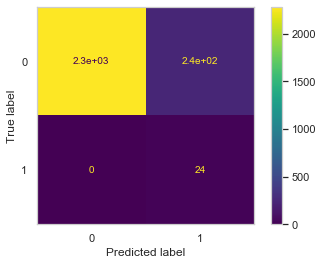

In [70]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

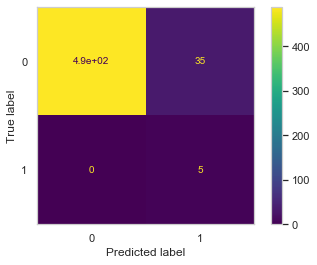

In [71]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [72]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([0.01162151, 0.01115588, 0.02189302, 0.02360361, 0.03601488])

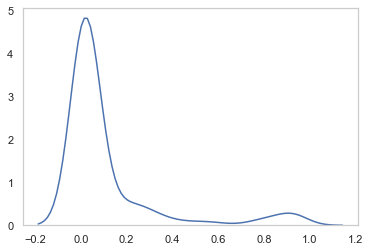

In [73]:
sns.kdeplot(y_pred);

In [74]:
metrics.confusion_matrix(y_test, y_pred > 1e-10)

array([[  0, 524],
       [  0,   5]])

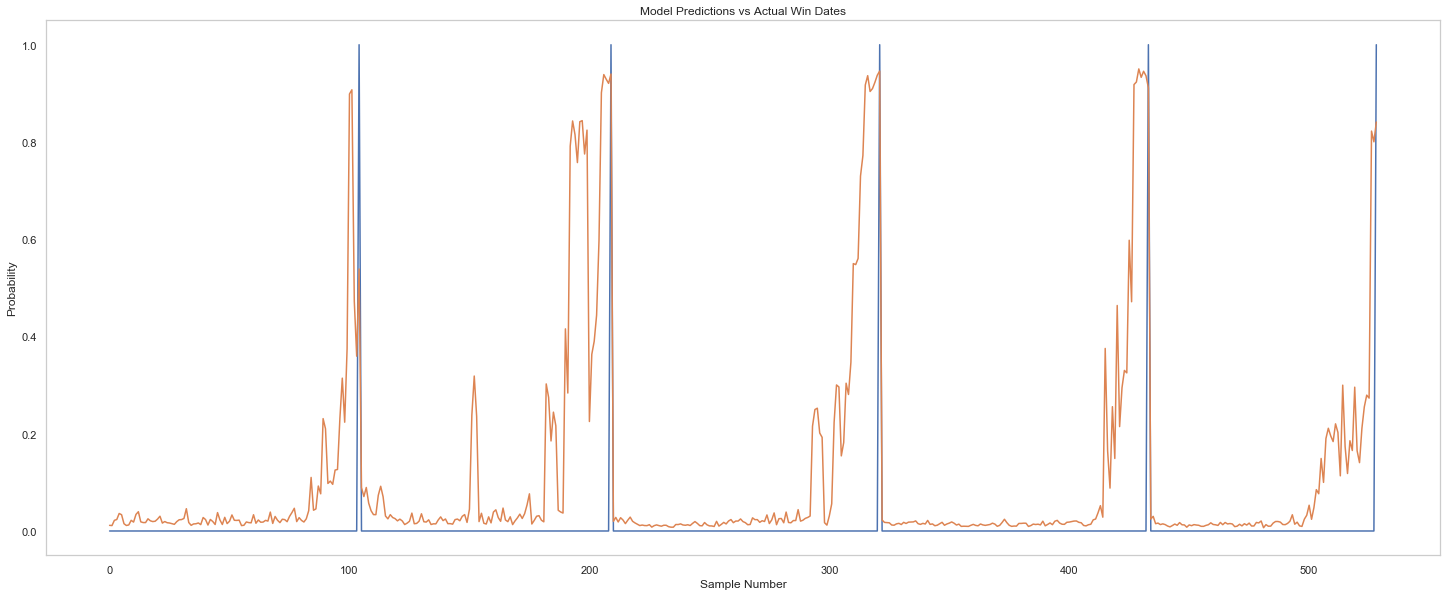

In [75]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

In [76]:
# get the top features by coefficient
feature_values = []
for n, v in enumerate(clf_lr.coef_[0]):
    feature_values.append((n, v))
sorted(feature_values, key = lambda x: abs(x[1]), reverse = True)[:31]

[(50, 0.3645638337362277),
 (57, 0.3234322960698392),
 (60, 0.19037184074200314),
 (8, 0.17036050456787363),
 (33, 0.15270032842780362),
 (13, 0.14349094133206944),
 (52, 0.12309430241346891),
 (2, 0.11829117455040879),
 (43, 0.11513089129219116),
 (4, 0.10905826245378374),
 (22, 0.10836663882871592),
 (34, 0.1050869640311995),
 (1, 0.10364630721779876),
 (55, -0.10195441209603218),
 (18, 0.10132065859850108),
 (44, 0.0939312047426577),
 (59, 0.08709553016682642),
 (19, 0.07909666624422741),
 (49, 0.07844627655824739),
 (29, 0.07681593045360628),
 (23, 0.0759464934407983),
 (14, 0.07507125245321272),
 (56, -0.06688338634356138),
 (15, -0.06681008540793207),
 (5, -0.06676988285415555),
 (45, -0.06427910985506494),
 (3, 0.06255619596698175),
 (54, -0.06158937885592219),
 (26, -0.06105052004629289),
 (58, -0.060479517637806124),
 (7, -0.06032676858735711)]

In [77]:
# list the feature names so the top 30 feature list can be made
feature_names = {}
for n, v in enumerate(used_ma5_cols):
    feature_names[n] = v
pprint.pprint(feature_names, compact = True)

{0: 'moonPhase',
 1: 'humidity',
 2: 'windSpeed',
 3: 'windBearing',
 4: 'cloudCover',
 5: 'uvIndex',
 6: 'precipIntensity',
 7: 'iceThickness',
 8: 'flowVolume',
 9: 'dayOfYear',
 10: 'daylightHours',
 11: 'precip_rain',
 12: 'precip_snow',
 13: 'temperatureAvg',
 14: 'numHotDays',
 15: 'numColdDays',
 16: 'accumulatedSnow',
 17: 'humidity_MA_5',
 18: 'humidity_MA-slope_5',
 19: 'humidity_MA-accel_5',
 20: 'humidity_MA-std_dev_5',
 21: 'windSpeed_MA_5',
 22: 'windSpeed_MA-slope_5',
 23: 'windSpeed_MA-accel_5',
 24: 'windSpeed_MA-std_dev_5',
 25: 'windBearing_MA_5',
 26: 'windBearing_MA-slope_5',
 27: 'windBearing_MA-accel_5',
 28: 'windBearing_MA-std_dev_5',
 29: 'cloudCover_MA_5',
 30: 'cloudCover_MA-slope_5',
 31: 'cloudCover_MA-accel_5',
 32: 'cloudCover_MA-std_dev_5',
 33: 'uvIndex_MA_5',
 34: 'uvIndex_MA-slope_5',
 35: 'uvIndex_MA-accel_5',
 36: 'uvIndex_MA-std_dev_5',
 37: 'precipIntensity_MA_5',
 38: 'precipIntensity_MA-slope_5',
 39: 'precipIntensity_MA-accel_5',
 40: 'precipI

In [78]:
lr_best_ma5_cols = []
for value in sorted(feature_values, key = lambda x: abs(x[1]), reverse = True)[:31]:
    if value[0] in feature_names:
        lr_best_ma5_cols.append(feature_names[value[0]])

In [79]:
lr_best_ma5_cols

['numHotDays_MA-slope_5',
 'flowVolume_MA_5',
 'flowVolume_MA-std_dev_5',
 'flowVolume',
 'uvIndex_MA_5',
 'temperatureAvg',
 'numHotDays_MA-std_dev_5',
 'windSpeed',
 'iceThickness_MA-accel_5',
 'cloudCover',
 'windSpeed_MA-slope_5',
 'uvIndex_MA-slope_5',
 'humidity',
 'numColdDays_MA-accel_5',
 'humidity_MA-slope_5',
 'iceThickness_MA-std_dev_5',
 'flowVolume_MA-accel_5',
 'humidity_MA-accel_5',
 'numHotDays_MA_5',
 'cloudCover_MA_5',
 'windSpeed_MA-accel_5',
 'numHotDays',
 'numColdDays_MA-std_dev_5',
 'numColdDays',
 'uvIndex',
 'temperatureAvg_MA_5',
 'windBearing',
 'numColdDays_MA-slope_5',
 'windBearing_MA-slope_5',
 'flowVolume_MA-slope_5',
 'iceThickness']

##### 7 Day Moving Average Features

In [80]:
ma7_cols = [c for c in training_df.columns.tolist() if not c.endswith(('3', '5', '10'))]
used_ma7_cols = [c for c in ma7_cols if c not in exclude]

In [81]:
# Logistic Regression model using all 7 day moving average features
target = 'winningDate'

scaler = RobustScaler()
encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
clf_lr = LogisticRegressionCV(class_weight='balanced', # class imbalance in data
                              Cs = [0.0036], # more features seem to respond better to stronger regularization
                              cv = TimeSeriesSplit(), # time series, so use TimeSeriesSplit
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)

pipe = make_pipeline(scaler, binner, objectify, encoder, clf_lr)

X_train, y_train = training_df[used_ma7_cols].values, training_df[target].values

In [82]:
pipe.fit(X_train, y_train)
X_test = testing_df[used_ma7_cols]
y_test = testing_df[target]
y_pred = pipe.predict(X_test)

In [83]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.9224952741020794


In [84]:
sns.set_style("whitegrid", {'axes.grid' : False})

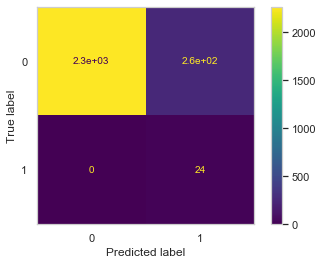

In [85]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

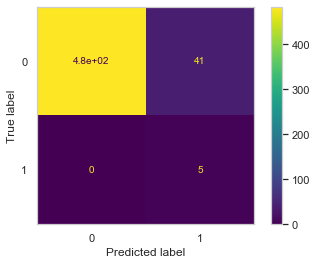

In [86]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [87]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([0.03510398, 0.02182613, 0.02499224, 0.03651125, 0.09320738])

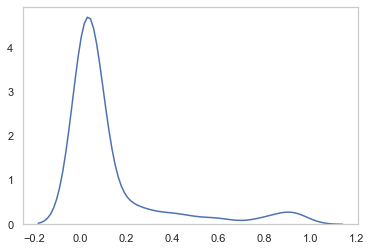

In [88]:
sns.kdeplot(y_pred);

In [89]:
metrics.confusion_matrix(y_test, y_pred > 1e-10)

array([[  0, 524],
       [  0,   5]])

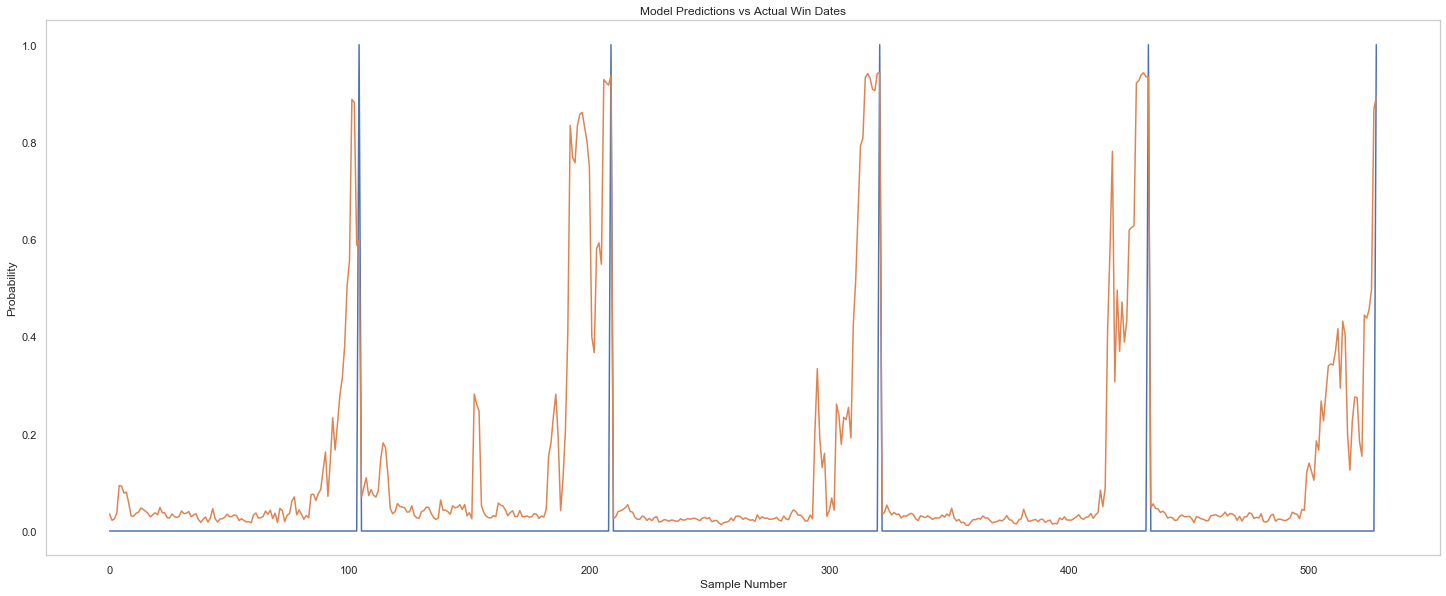

In [90]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

In [91]:
# get the top features by coefficient
feature_values = []
for n, v in enumerate(clf_lr.coef_[0]):
    feature_values.append((n, v))
sorted(feature_values, key = lambda x: abs(x[1]), reverse = True)[:31]

[(50, 0.34220807662430325),
 (57, 0.23699487392232887),
 (44, 0.15676989976169742),
 (48, 0.1518586977556204),
 (60, 0.14241230214507883),
 (13, 0.14007559042882617),
 (58, 0.1360432600456087),
 (8, 0.10501198929007252),
 (49, 0.0862190344840476),
 (42, 0.0800626658685611),
 (33, 0.07710371426085656),
 (26, 0.07553445569461345),
 (14, 0.0708418864740645),
 (25, 0.07057554038062512),
 (1, 0.06788639191513479),
 (46, 0.0677865235568747),
 (23, 0.06323579890095389),
 (43, 0.06214018011030999),
 (2, 0.06177195124596327),
 (32, 0.05907889908974327),
 (56, -0.05712395186726266),
 (4, 0.053744429659757544),
 (7, -0.05122533662415935),
 (55, -0.05039271097123554),
 (51, -0.049062033577858405),
 (29, 0.04839704896598069),
 (34, -0.04806491959439731),
 (59, 0.046688492146236875),
 (15, -0.0436385447498689),
 (31, -0.0414554834116679),
 (9, 0.039607068589149426)]

In [92]:
# list the feature names so the top 30 feature list can be made
feature_names = {}
for n, v in enumerate(used_ma7_cols):
    feature_names[n] = v
pprint.pprint(feature_names, compact = True)

{0: 'moonPhase',
 1: 'humidity',
 2: 'windSpeed',
 3: 'windBearing',
 4: 'cloudCover',
 5: 'uvIndex',
 6: 'precipIntensity',
 7: 'iceThickness',
 8: 'flowVolume',
 9: 'dayOfYear',
 10: 'daylightHours',
 11: 'precip_rain',
 12: 'precip_snow',
 13: 'temperatureAvg',
 14: 'numHotDays',
 15: 'numColdDays',
 16: 'accumulatedSnow',
 17: 'humidity_MA_7',
 18: 'humidity_MA-slope_7',
 19: 'humidity_MA-accel_7',
 20: 'humidity_MA-std_dev_7',
 21: 'windSpeed_MA_7',
 22: 'windSpeed_MA-slope_7',
 23: 'windSpeed_MA-accel_7',
 24: 'windSpeed_MA-std_dev_7',
 25: 'windBearing_MA_7',
 26: 'windBearing_MA-slope_7',
 27: 'windBearing_MA-accel_7',
 28: 'windBearing_MA-std_dev_7',
 29: 'cloudCover_MA_7',
 30: 'cloudCover_MA-slope_7',
 31: 'cloudCover_MA-accel_7',
 32: 'cloudCover_MA-std_dev_7',
 33: 'uvIndex_MA_7',
 34: 'uvIndex_MA-slope_7',
 35: 'uvIndex_MA-accel_7',
 36: 'uvIndex_MA-std_dev_7',
 37: 'precipIntensity_MA_7',
 38: 'precipIntensity_MA-slope_7',
 39: 'precipIntensity_MA-accel_7',
 40: 'precipI

In [93]:
lr_best_ma7_cols = []
for value in sorted(feature_values, key = lambda x: abs(x[1]), reverse = True)[:31]:
    if value[0] in feature_names:
        lr_best_ma7_cols.append(feature_names[value[0]])

In [94]:
lr_best_ma7_cols

['numHotDays_MA-slope_7',
 'flowVolume_MA_7',
 'iceThickness_MA-std_dev_7',
 'temperatureAvg_MA-std_dev_7',
 'flowVolume_MA-std_dev_7',
 'temperatureAvg',
 'flowVolume_MA-slope_7',
 'flowVolume',
 'numHotDays_MA_7',
 'iceThickness_MA-slope_7',
 'uvIndex_MA_7',
 'windBearing_MA-slope_7',
 'numHotDays',
 'windBearing_MA_7',
 'humidity',
 'temperatureAvg_MA-slope_7',
 'windSpeed_MA-accel_7',
 'iceThickness_MA-accel_7',
 'windSpeed',
 'cloudCover_MA-std_dev_7',
 'numColdDays_MA-std_dev_7',
 'cloudCover',
 'iceThickness',
 'numColdDays_MA-accel_7',
 'numHotDays_MA-accel_7',
 'cloudCover_MA_7',
 'uvIndex_MA-slope_7',
 'flowVolume_MA-accel_7',
 'numColdDays',
 'cloudCover_MA-accel_7',
 'dayOfYear']

##### 10 Day Moving Average Features

In [95]:
ma10_cols = [c for c in training_df.columns.tolist() if not c.endswith(('3', '5', '7'))]
used_ma10_cols = [c for c in ma10_cols if c not in exclude]

In [96]:
# Logistic Regression model using all 10 day moving average features
target = 'winningDate'

scaler = RobustScaler()
encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
clf_lr = LogisticRegressionCV(class_weight='balanced', # class imbalance in data
                              Cs = [0.015], # more features seem to respond better to stronger regularization
                              cv = TimeSeriesSplit(), # time series, so use TimeSeriesSplit
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)

pipe = make_pipeline(scaler, binner, objectify, encoder, clf_lr)

X_train, y_train = training_df[used_ma10_cols].values, training_df[target].values

In [97]:
pipe.fit(X_train, y_train)
X_test = testing_df[used_ma10_cols]
y_test = testing_df[target]
y_pred = pipe.predict(X_test)

In [98]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.9243856332703214


In [99]:
sns.set_style("whitegrid", {'axes.grid' : False})

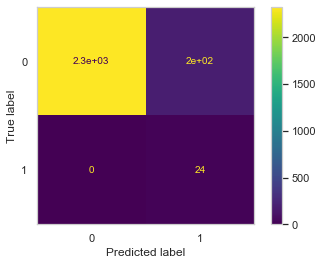

In [100]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

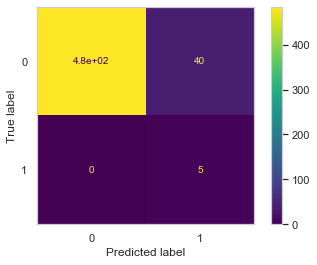

In [101]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [102]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([0.01199992, 0.0099628 , 0.01716519, 0.00969077, 0.0068386 ])

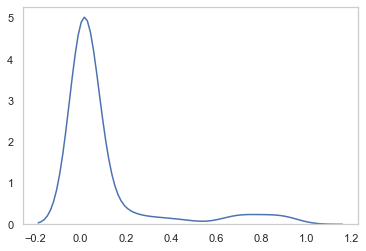

In [103]:
sns.kdeplot(y_pred);

In [104]:
metrics.confusion_matrix(y_test, y_pred > 1e-10)

array([[  0, 524],
       [  0,   5]])

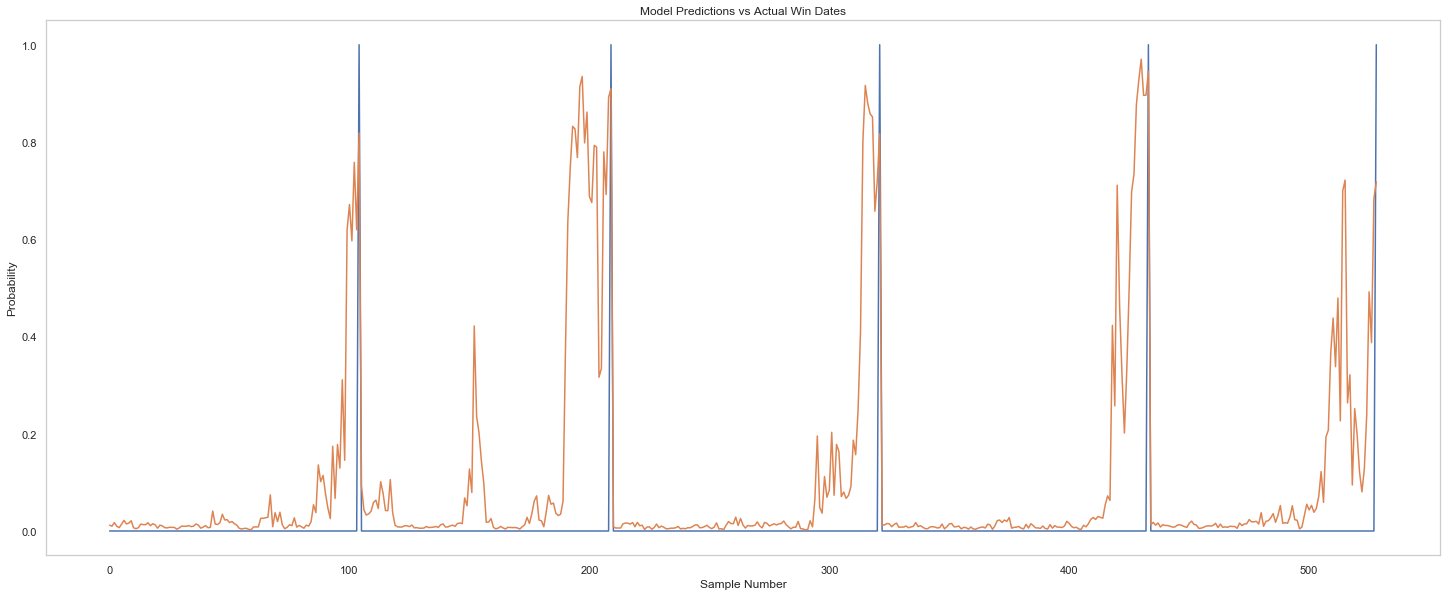

In [105]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

In [106]:
# get the top features by coefficient
feature_values = []
for n, v in enumerate(clf_lr.coef_[0]):
    feature_values.append((n, v))
sorted(feature_values, key = lambda x: abs(x[1]), reverse = True)[:31]

[(57, 0.5090183359453865),
 (44, 0.43540216792643593),
 (35, 0.32617130519483195),
 (13, 0.29544872487817614),
 (27, 0.2752215948819376),
 (52, 0.26079797445267044),
 (51, -0.2263628753233493),
 (45, -0.217562097090312),
 (31, 0.1873855112822212),
 (50, 0.18024104695971824),
 (49, 0.17087844406570507),
 (30, 0.17041690031831483),
 (58, 0.16945528337352148),
 (2, 0.16473863551041348),
 (4, 0.15651480243698546),
 (34, -0.15460249349199903),
 (1, 0.1494164287429706),
 (36, 0.14345243144810177),
 (7, -0.12884498158969984),
 (20, 0.12731778331409566),
 (48, 0.12302255835115658),
 (56, -0.11499487863976414),
 (46, 0.11380386323819788),
 (40, -0.09898728515637338),
 (15, -0.0983936996627415),
 (16, -0.09725731613386158),
 (53, -0.09687705105585126),
 (55, -0.09682889722137566),
 (37, -0.09468807525460636),
 (39, -0.09442171031929794),
 (5, -0.09273091600189681)]

In [107]:
# list the feature names so the top 30 feature list can be made
feature_names = {}
for n, v in enumerate(used_ma10_cols):
    feature_names[n] = v
pprint.pprint(feature_names, compact = True)

{0: 'moonPhase',
 1: 'humidity',
 2: 'windSpeed',
 3: 'windBearing',
 4: 'cloudCover',
 5: 'uvIndex',
 6: 'precipIntensity',
 7: 'iceThickness',
 8: 'flowVolume',
 9: 'dayOfYear',
 10: 'daylightHours',
 11: 'precip_rain',
 12: 'precip_snow',
 13: 'temperatureAvg',
 14: 'numHotDays',
 15: 'numColdDays',
 16: 'accumulatedSnow',
 17: 'humidity_MA_10',
 18: 'humidity_MA-slope_10',
 19: 'humidity_MA-accel_10',
 20: 'humidity_MA-std_dev_10',
 21: 'windSpeed_MA_10',
 22: 'windSpeed_MA-slope_10',
 23: 'windSpeed_MA-accel_10',
 24: 'windSpeed_MA-std_dev_10',
 25: 'windBearing_MA_10',
 26: 'windBearing_MA-slope_10',
 27: 'windBearing_MA-accel_10',
 28: 'windBearing_MA-std_dev_10',
 29: 'cloudCover_MA_10',
 30: 'cloudCover_MA-slope_10',
 31: 'cloudCover_MA-accel_10',
 32: 'cloudCover_MA-std_dev_10',
 33: 'uvIndex_MA_10',
 34: 'uvIndex_MA-slope_10',
 35: 'uvIndex_MA-accel_10',
 36: 'uvIndex_MA-std_dev_10',
 37: 'precipIntensity_MA_10',
 38: 'precipIntensity_MA-slope_10',
 39: 'precipIntensity_MA-a

In [108]:
lr_best_ma10_cols = []
for value in sorted(feature_values, key = lambda x: abs(x[1]), reverse = True)[:31]:
    if value[0] in feature_names:
        lr_best_ma10_cols.append(feature_names[value[0]])

In [109]:
lr_best_ma10_cols

['flowVolume_MA_10',
 'iceThickness_MA-std_dev_10',
 'uvIndex_MA-accel_10',
 'temperatureAvg',
 'windBearing_MA-accel_10',
 'numHotDays_MA-std_dev_10',
 'numHotDays_MA-accel_10',
 'temperatureAvg_MA_10',
 'cloudCover_MA-accel_10',
 'numHotDays_MA-slope_10',
 'numHotDays_MA_10',
 'cloudCover_MA-slope_10',
 'flowVolume_MA-slope_10',
 'windSpeed',
 'cloudCover',
 'uvIndex_MA-slope_10',
 'humidity',
 'uvIndex_MA-std_dev_10',
 'iceThickness',
 'humidity_MA-std_dev_10',
 'temperatureAvg_MA-std_dev_10',
 'numColdDays_MA-std_dev_10',
 'temperatureAvg_MA-slope_10',
 'precipIntensity_MA-std_dev_10',
 'numColdDays',
 'accumulatedSnow',
 'numColdDays_MA_10',
 'numColdDays_MA-accel_10',
 'precipIntensity_MA_10',
 'precipIntensity_MA-accel_10',
 'uvIndex']

---
#### Logistic Regression Model Using Top 20 Features From Baseline Model

In [110]:
target = 'winningDate'

scaler = RobustScaler()
encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)
pipe = make_pipeline(scaler, binner, objectify, encoder, clf_lr)

X_train, y_train = training_df[lr_best_cols].values, training_df[target].values

In [111]:
pipe.fit(X_train, y_train)
X_test = testing_df[lr_best_cols]
y_test = testing_df[target]
y_pred = pipe.predict(X_test)

In [112]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.9792060491493384


In [113]:
sns.set_style("whitegrid", {'axes.grid' : False})

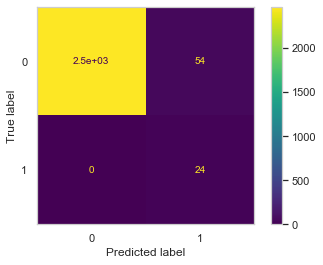

In [114]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

In [115]:
metrics.confusion_matrix(y_test, y_pred)

array([[516,   8],
       [  3,   2]])

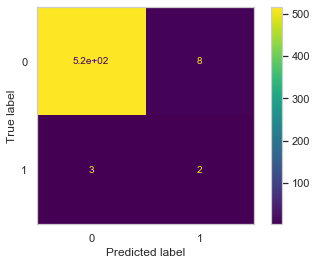

In [116]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [117]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([9.25589211e-10, 1.18675939e-09, 1.24095022e-10, 2.22608034e-12,
       3.18913854e-11])

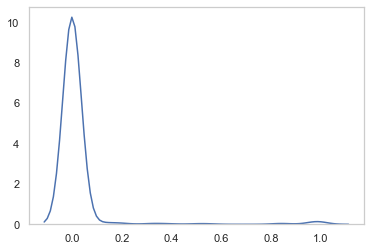

In [118]:
sns.kdeplot(y_pred);

In [119]:
metrics.confusion_matrix(y_test, y_pred > 0.15)

array([[509,  15],
       [  3,   2]])

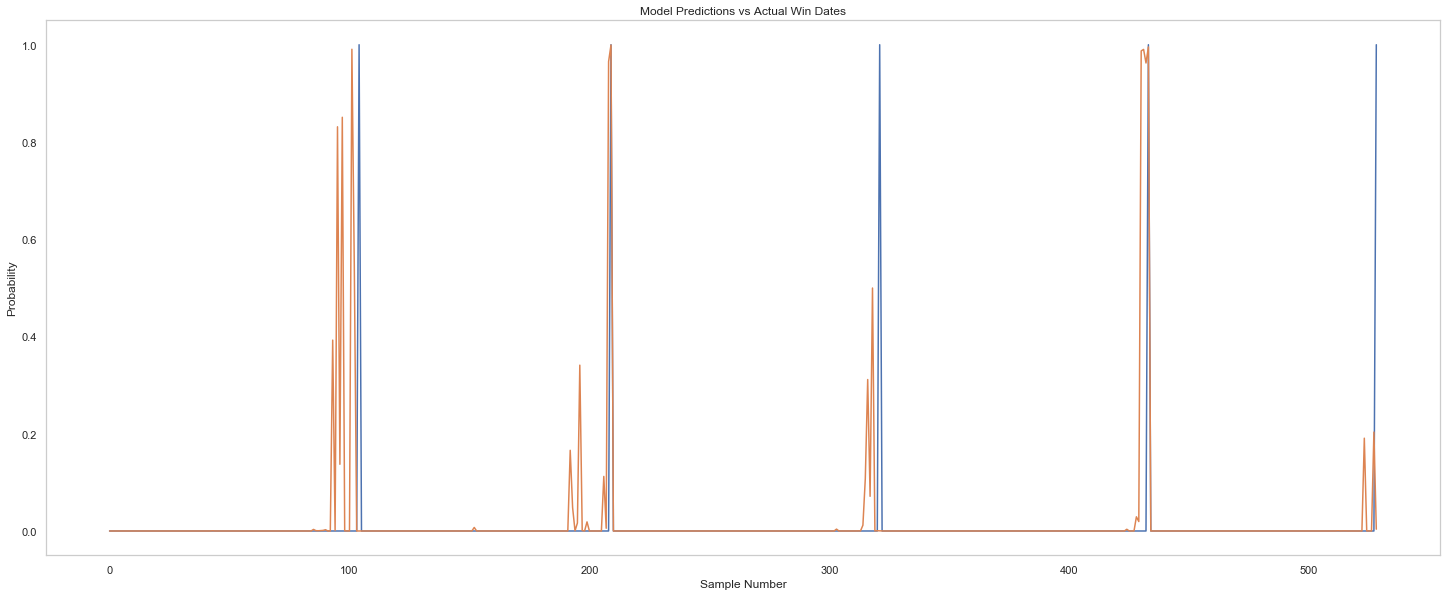

In [120]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

In [121]:
pprint.pprint(lr_best_cols, compact = True)

['numHotDays_MA-slope_5', 'numHotDays_MA-slope_7', 'flowVolume_MA_10',
 'flowVolume_MA_7', 'numHotDays_MA-std_dev_5', 'flowVolume_MA_5',
 'temperatureAvg_MA-std_dev_7', 'flowVolume_MA-slope_7', 'uvIndex_MA-accel_10',
 'numHotDays_MA-std_dev_10', 'flowVolume_MA-std_dev_7',
 'iceThickness_MA-std_dev_10', 'flowVolume_MA_3', 'flowVolume_MA-slope_10',
 'iceThickness_MA-std_dev_7', 'flowVolume_MA-std_dev_5',
 'numHotDays_MA-std_dev_3', 'numHotDays_MA-slope_10', 'uvIndex_MA-std_dev_10',
 'uvIndex_MA_5', 'temperatureAvg', 'flowVolume', 'flowVolume_MA-std_dev_10',
 'numHotDays_MA-accel_10', 'flowVolume_MA-accel_5', 'flowVolume_MA-std_dev_3',
 'uvIndex_MA_10', 'flowVolume_MA-accel_10', 'numHotDays_MA_10', 'humidity_MA_3',
 'windBearing_MA-accel_10']


---
#### Principal Component Analysis
It was suggested to me that PCA would be quicker and potentially more effective than my initial approach.

In [122]:
# Logistic Regression model using PCA
pca_exclude = ['precip_snow', 'precip_rain', 'winningDate', 'winningTime', 'Date']
used_cols = [c for c in used_ma5_cols if c not in pca_exclude]

target = 'winningDate'

scaler = RobustScaler()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
encoder = WOEEncoder()
pca = KPCA(n_components = 30,
           random_state = 42,
           n_jobs = -1)

clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)

pipe = make_pipeline(scaler, binner, objectify, encoder, pca, clf_lr)

X_train, y_train = training_df[used_cols].values, training_df[target].values

In [123]:
pipe.fit(X_train, y_train)
X_test = testing_df[used_cols]
y_test = testing_df[target]
y_pred = pipe.predict(X_test)

In [124]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.9810964083175804


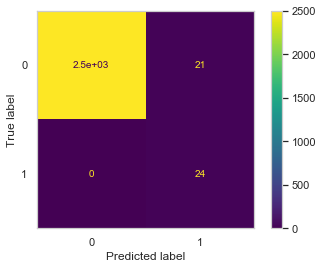

In [125]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

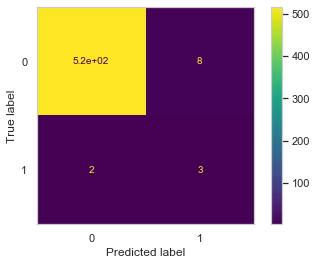

In [126]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [127]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([1.05905228e-132, 4.99572520e-131, 7.34258868e-124, 2.01500785e-118,
       2.73180065e-071])

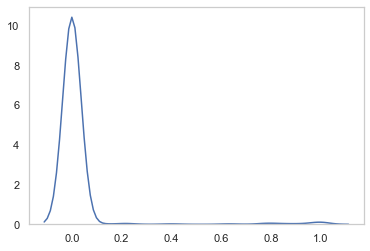

In [128]:
sns.kdeplot(y_pred);

In [129]:
metrics.confusion_matrix(y_test, y_pred > 1e-70)

array([[433,  91],
       [  0,   5]])

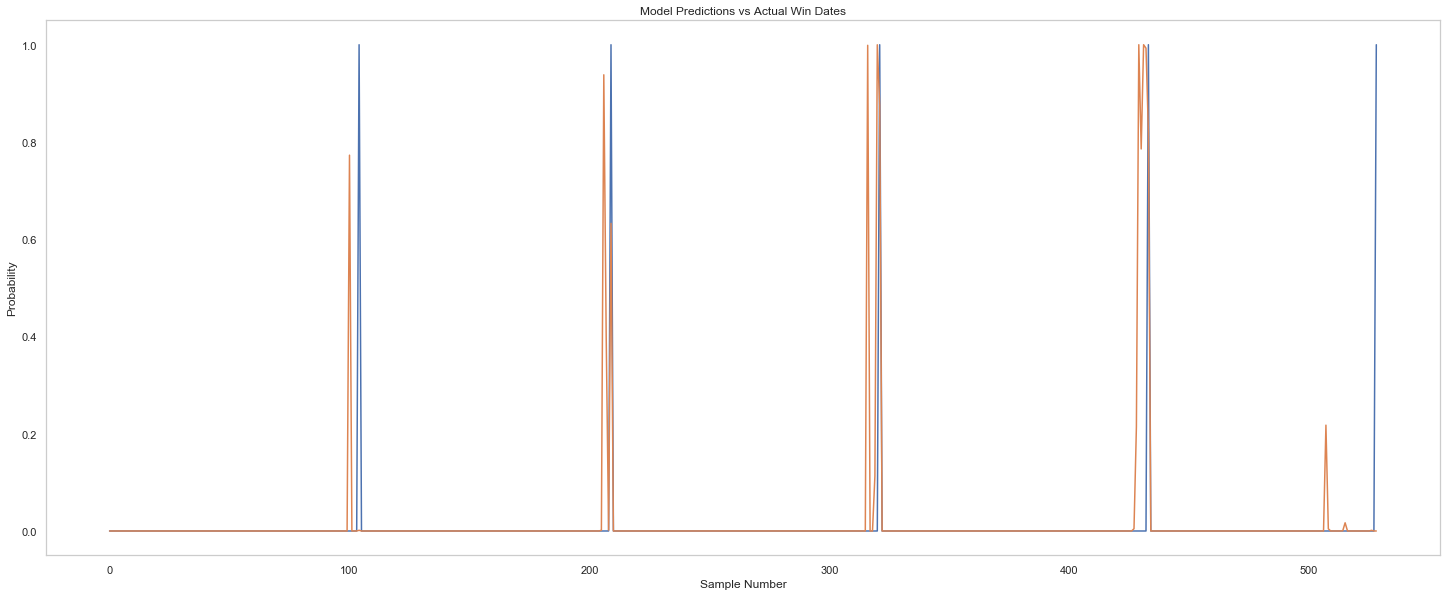

In [130]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

---
#### Reducing The Number Of Principal Components
Experiment with 20 principal components

In [131]:
# Logistic Regression model using PCA
target = 'winningDate'

scaler = RobustScaler()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
encoder = WOEEncoder()
pca = KPCA(n_components = 20,
           random_state = 42,
           n_jobs = -1)

clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)

pipe = make_pipeline(scaler, binner, objectify, encoder, pca, clf_lr)

X_train, y_train = training_df[used_cols].values, training_df[target].values

In [132]:
pipe.fit(X_train, y_train)
X_test = testing_df[used_cols]
y_test = testing_df[target]
y_pred = pipe.predict(X_test)

In [133]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.9810964083175804


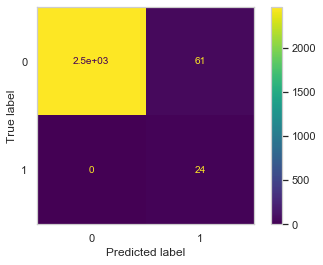

In [134]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

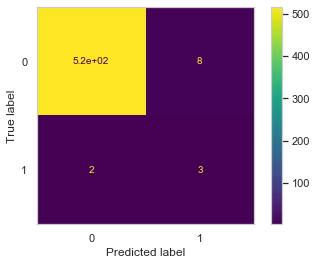

In [135]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [136]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([1.85666231e-73, 1.37493261e-73, 3.26917531e-71, 9.76278609e-70,
       4.73592165e-65])

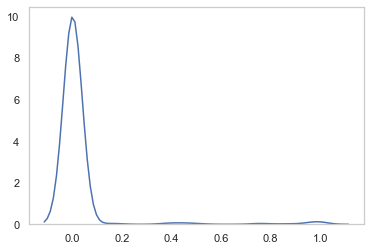

In [137]:
sns.kdeplot(y_pred);

In [138]:
metrics.confusion_matrix(y_test, y_pred > 1e-8)

array([[497,  27],
       [  1,   4]])

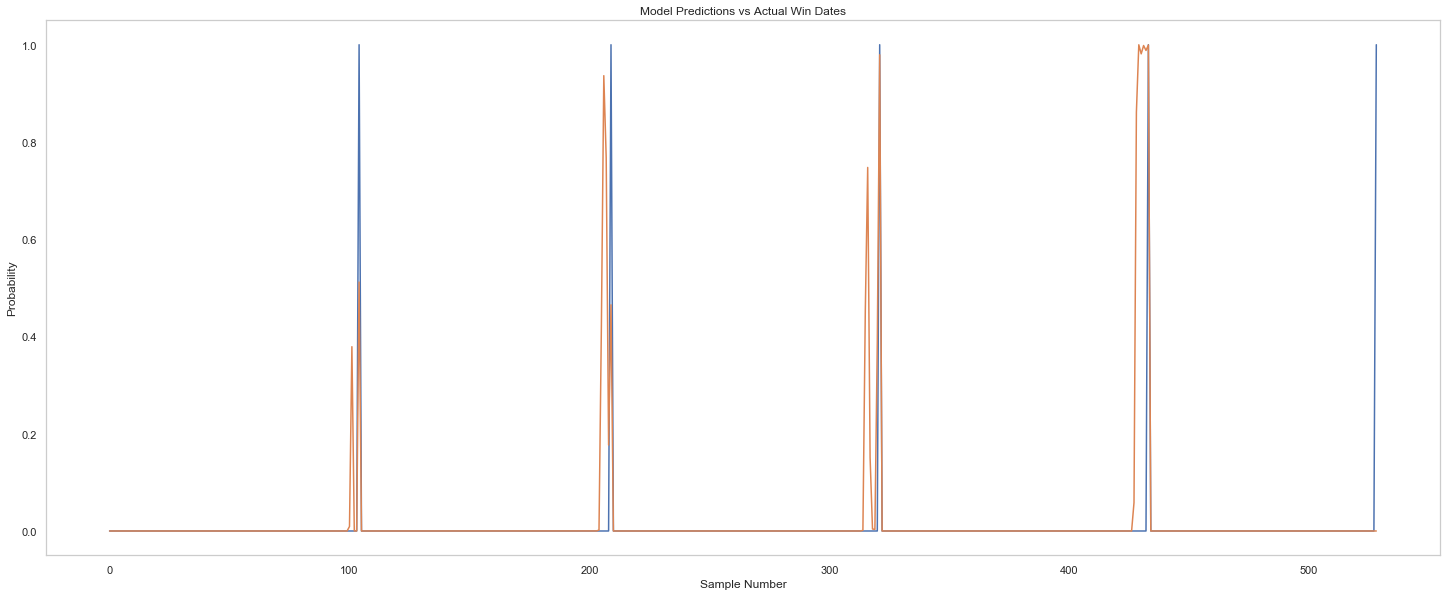

In [139]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

---
#### Reducing The Number Of Principal Components
Experiment with 10 principal components

In [140]:
# Logistic Regression model using PCA
target = 'winningDate'

scaler = RobustScaler()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
encoder = WOEEncoder()
pca = KPCA(n_components = 10,
           random_state = 42,
           n_jobs = -1)

clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)

pipe = make_pipeline(scaler, binner, objectify, encoder, pca, clf_lr)

X_train, y_train = training_df[used_cols].values, training_df[target].values

In [141]:
pipe.fit(X_train, y_train)
X_test = testing_df[used_cols]
y_test = testing_df[target]
y_pred = pipe.predict(X_test)

In [142]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.9603024574669187


In [143]:
sns.set_style("whitegrid", {'axes.grid' : False})

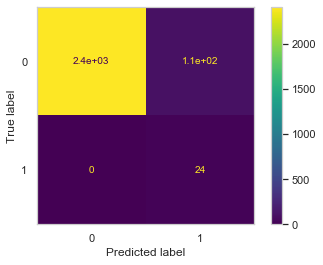

In [144]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

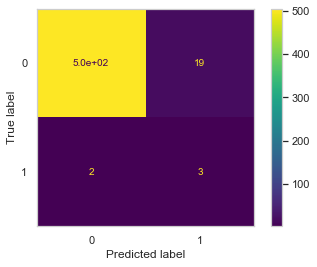

In [145]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [146]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([1.72321090e-41, 6.80190235e-41, 1.36657436e-39, 7.06093327e-40,
       1.78008348e-37])

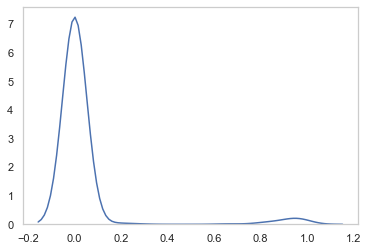

In [147]:
sns.kdeplot(y_pred);

In [148]:
metrics.confusion_matrix(y_test, y_pred > 1e-3)

array([[496,  28],
       [  1,   4]])

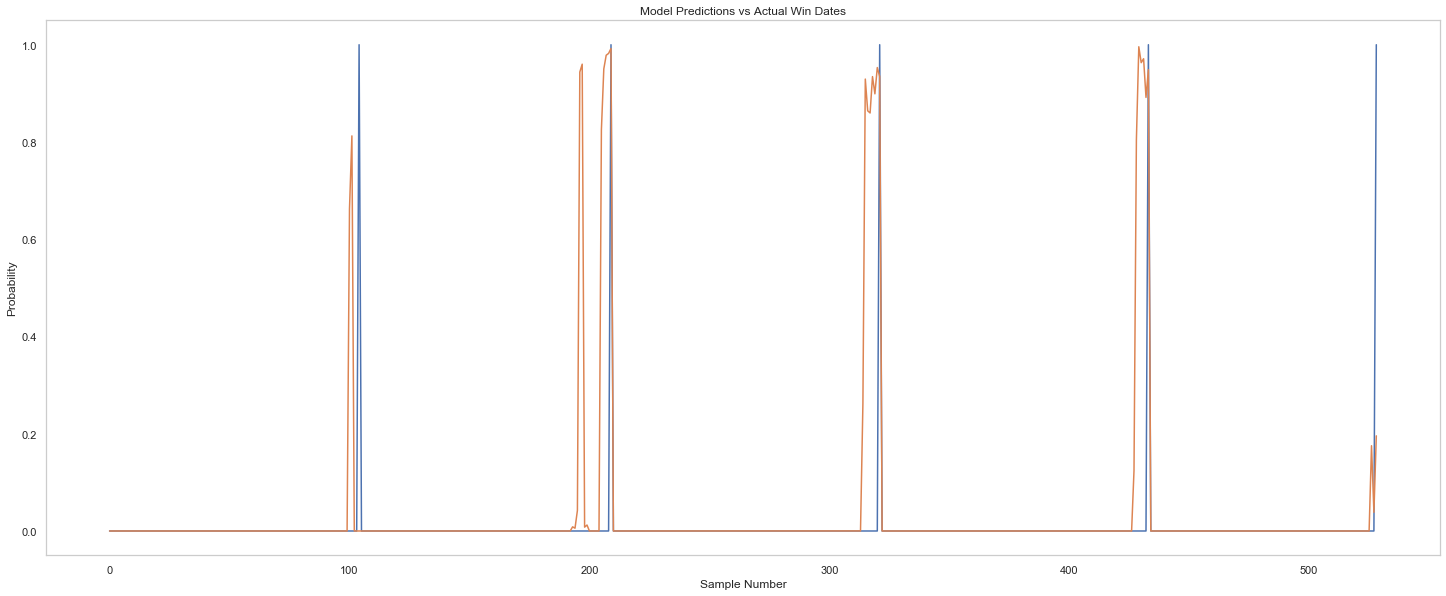

In [149]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

---
#### Reducing The Number Of Principal Components
Experiment with 5 principal components

In [150]:
# Logistic Regression model using PCA
target = 'winningDate'

scaler = RobustScaler()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
encoder = WOEEncoder()
pca = KPCA(n_components = 5,
           random_state = 42,
           n_jobs = -1)

clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)

pipe = make_pipeline(scaler, binner, objectify, encoder, pca, clf_lr)

X_train, y_train = training_df[used_cols].values, training_df[target].values

In [151]:
pipe.fit(X_train, y_train)
X_test = testing_df[used_cols]
y_test = testing_df[target]
y_pred = pipe.predict(X_test)

In [152]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.9621928166351607


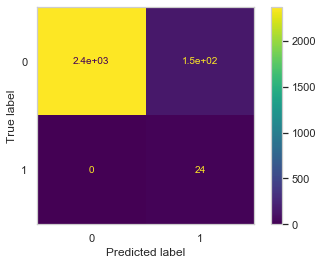

In [153]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

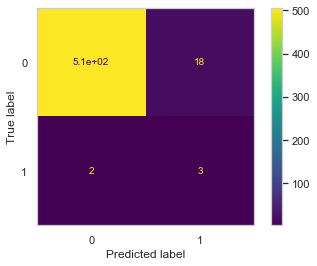

In [154]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [155]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([2.62780790e-16, 4.97340265e-16, 7.24867148e-15, 4.25513078e-15,
       2.54627725e-13])

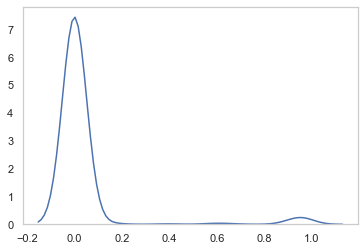

In [156]:
sns.kdeplot(y_pred);

In [157]:
metrics.confusion_matrix(y_test, y_pred > 0.09)

array([[502,  22],
       [  2,   3]])

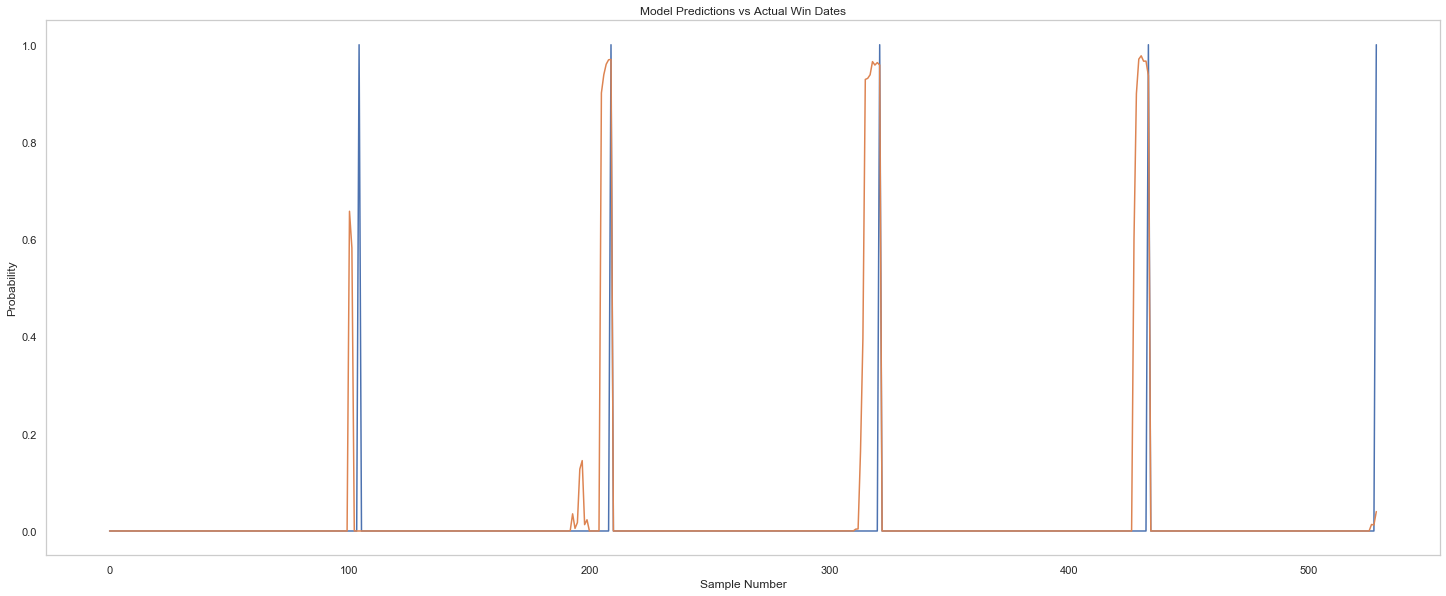

In [158]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

---
#### Reducing The Number Of Principal Components
Experiment with 3 principal components

In [159]:
# Logistic Regression model using PCA
target = 'winningDate'

scaler = RobustScaler()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
encoder = WOEEncoder()
pca = KPCA(n_components = 3,
           random_state = 42,
           n_jobs = -1)

clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)

pipe = make_pipeline(scaler, binner, objectify, encoder, pca, clf_lr)

X_train, y_train = training_df[used_cols].values, training_df[target].values

In [160]:
pipe.fit(X_train, y_train)
X_test = testing_df[used_cols]
y_test = testing_df[target]
y_pred = pipe.predict(X_test)

In [161]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.9621928166351607


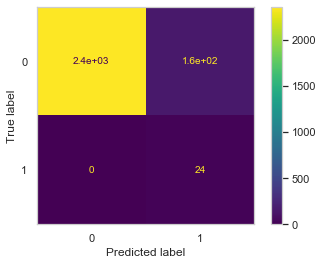

In [162]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

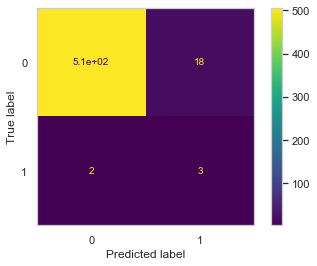

In [163]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [164]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([9.55116156e-14, 1.27522237e-13, 5.69677478e-12, 2.98738286e-12,
       3.10396285e-10])

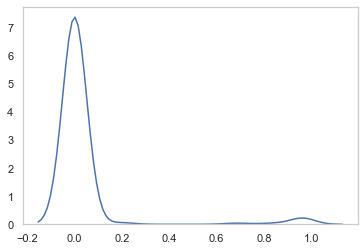

In [165]:
sns.kdeplot(y_pred);

In [166]:
metrics.confusion_matrix(y_test, y_pred > 0.09)

array([[502,  22],
       [  2,   3]])

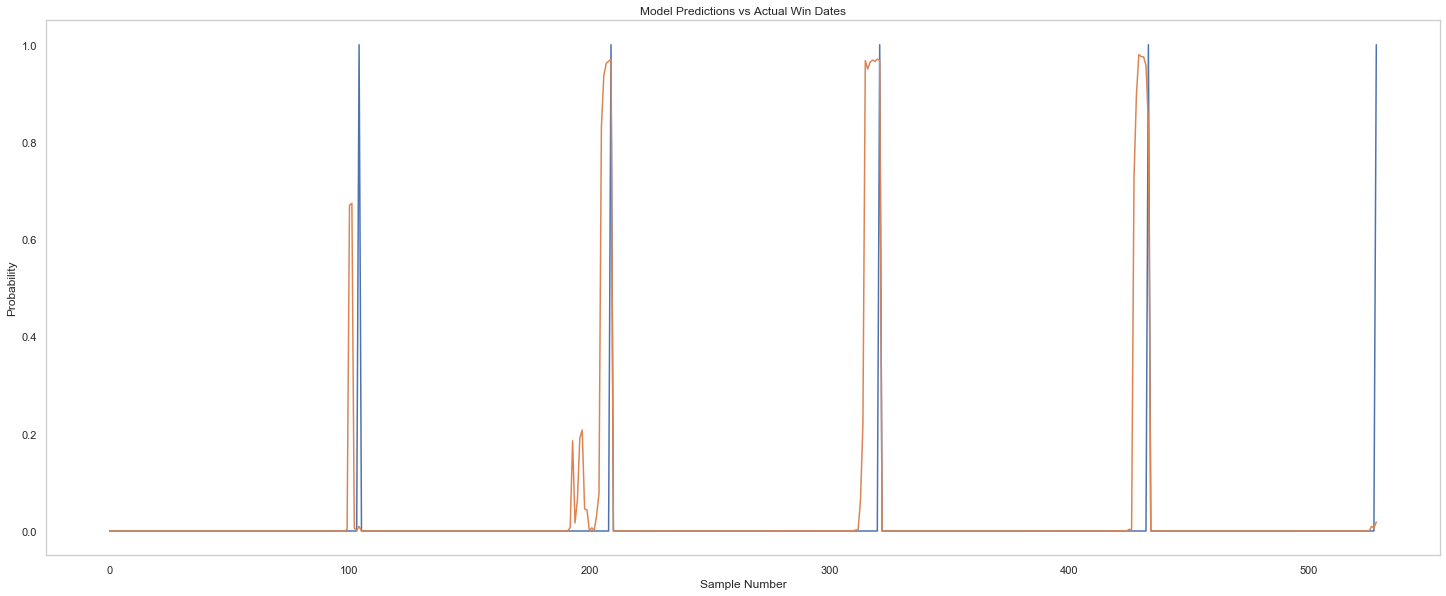

In [167]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

---
TODO: try combinations of moving average features

In [169]:
lr_best_ma3_cols[:5]

['humidity_MA-std_dev_3',
 'flowVolume_MA_3',
 'cloudCover_MA_3',
 'windSpeed_MA-slope_3',
 'temperatureAvg']

In [170]:
lr_best_ma5_cols[:5]

['numHotDays_MA-slope_5',
 'flowVolume_MA_5',
 'flowVolume_MA-std_dev_5',
 'flowVolume',
 'uvIndex_MA_5']

In [171]:
lr_best_ma7_cols[:5]

['numHotDays_MA-slope_7',
 'flowVolume_MA_7',
 'iceThickness_MA-std_dev_7',
 'temperatureAvg_MA-std_dev_7',
 'flowVolume_MA-std_dev_7']

In [175]:
lr_best_ma10_cols[:5]

['flowVolume_MA_10',
 'iceThickness_MA-std_dev_10',
 'uvIndex_MA-accel_10',
 'temperatureAvg',
 'windBearing_MA-accel_10']